# Running Shoebot as a module in Jupyter

Shoebot can be run as a Python module. This notebook contains 
some usage examples, as well as dealing directly with Cairo surfaces.

This approach doesn't use the kernel, meaning that you don't require 
`shoebot-jupyter` for these examples to work.

See below for a couple of interesting uses of this feature.

In [1]:
# First, imports!

import shoebot
import cairocffi as cairo
from io import BytesIO
from IPython.display import Image, SVG, display

TL;DR: Use `show()` to see the results of a set of drawing commands. Read below for some more verbose variations using Cairo surfaces.

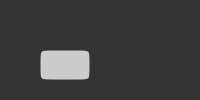

In [2]:
bot = shoebot.create_bot()
bot.size(200, 100)
bot.background(0.2)
bot.fill(0.8)
bot.rect(40, 50, 50, 30, .4)
bot.show()

The following examples are the attempts that led to the implementation of `show()`. We're leaving them here since they showcase many ways to achieve the same output.

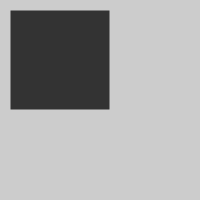

In [3]:
bot = shoebot.create_bot(outputfile='example1.png')

bot.size(200, 200)
bot.background(0.8)

bot.fill(0.2)
bot.rect(10, 10, 100, 100)
bot.finish()

Image('example1.png')

PNGs are fine, but SVGs are currently buggy. See the Bugs section below for an example of this.

Now, let's try using a Cairo surface instead of a filename.

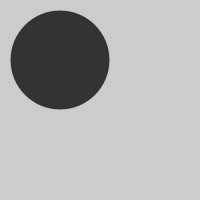

In [4]:
surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, 200, 200)
ctx = cairo.Context(surface)
bot = shoebot.create_bot(surface)

bot.size(200, 200)
bot.background(0.8)
bot.fill(0.2)
bot.ellipse(10, 10, 100, 100)
# clunky call, but that's the only way I could do this
bot._canvas._drawqueue.render(ctx)

surface.write_to_png('example2.png')
Image('example2.png')

SVG also works here when using Cairo surfaces. (with filenames it does not, see the Bugs section below)

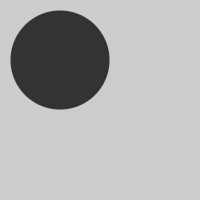

In [5]:
surface = cairo.SVGSurface('example.svg', 200, 200)
ctx = cairo.Context(surface)
bot = shoebot.create_bot(surface)

bot.size(200, 200)
bot.background(0.8)
bot.fill(0.2)
bot.ellipse(10, 10, 100, 100)
# clunky call, but that's the only way I could do this
bot._canvas._drawqueue.render(ctx)
bot.finish()

SVG('example.svg')

We can skip working with files by storing the PNG data in a byte string in memory, without generating an intermediate file.

This logic comes from [cairo-jupyter](https://github.com/fomightez/cairo-jupyter).

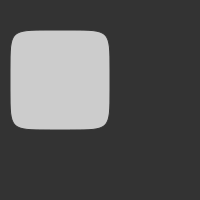

In [6]:
surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, 200, 200)
ctx = cairo.Context(surface)
bot = shoebot.create_bot(surface)
b = BytesIO()

bot.size(200, 180)
bot.background(0.2)
bot.fill(0.8)
bot.rect(10, 30, 100, 100, .4)
bot._canvas._drawqueue.render(ctx)

surface.write_to_png(b)
b.seek(0)
data = b.read()
Image(data)

Now, let's try the same but creating the surface _after_ doing the draw commands.

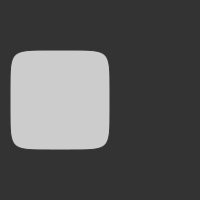

In [7]:
bot = shoebot.create_bot()
bot.size(200, 180)
bot.background(0.2)
bot.fill(0.8)
bot.rect(10, 50, 100, 100, .4)

surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, 200, 200)
ctx = cairo.Context(surface)
b = BytesIO()
bot._canvas._drawqueue.render(ctx)
surface.write_to_png(b)
b.seek(0)
data = b.read()
Image(data)

Sweet! Now let's try it with `bot.snapshot()`.

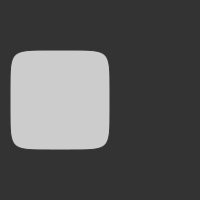

In [8]:
bot = shoebot.create_bot()
bot.size(200, 180)
bot.background(0.2)
bot.fill(0.8)
bot.rect(10, 50, 100, 100, .4)

surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, 200, 200)
b = BytesIO()
bot.snapshot(surface)
surface.write_to_png(b)
b.seek(0)
data = b.read()
Image(data)

This is exactly what you get by running `bot.show()`.

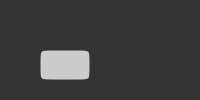

In [13]:
bot = shoebot.create_bot()
bot.size(200, 100)
bot.background(0.2)
bot.fill(0.8)
bot.rect(40, 50, 50, 30, .4)
bot.show()

## Showing bot output more than once

We can get previews with `bot.show()` and keep on drawing on the same canvas -- we just don't re-define `bot` and it will get the last run instance. Run the previous script and the one after this, and notice how the result is drawn on top of the previous canvas.

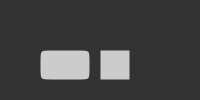

In [14]:
bot.rect(100, 50, 30, 30)
bot.show()

# Bugs

## Creating SVG by specifying a filename

This should work, but doesn't. The unhelpful traceback hides the detail that the SVG file is empty.

In [11]:
bot = shoebot.create_bot('example3.svg')

bot.size(200, 200)
bot.background(0.2)
bot.fill(0.8)
bot.rect(10, 10, 100, 100, .4)
bot.finish()

SVG('example3.svg')

ExpatError: syntax error: line 1, column 0